In [372]:
from database.data_importer import DataManagement
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
import numpy as np
import seaborn as sn

# Data Import

In [373]:
dm = DataManagement()
df = dm.db_query('select * from working_data')

In [374]:
df.head()

name                              instance   value         type  log_order  \
0  1506  f7b10faa-6e79-4444-929d-40e3fc74cdce  active        state          0   
1  1506  f7b10faa-6e79-4444-929d-40e3fc74cdce   77.72  measurement          1   
2  1506  f7b10faa-6e79-4444-929d-40e3fc74cdce   77.71  measurement          2   
3  1506  f7b10faa-6e79-4444-929d-40e3fc74cdce    77.7  measurement          3   
4  1506  f7b10faa-6e79-4444-929d-40e3fc74cdce   77.69  measurement          4   

                       timestamp batch parent_id m_name m_instance  \
0  2020-11-03T18:48:43.060+01:00    10      None   None       None   
1  2020-11-03T18:48:43.062+01:00    10      None   None       None   
2  2020-11-03T18:48:43.085+01:00    10      None   None       None   
3  2020-11-03T18:48:43.139+01:00    10      None   None       None   
4  2020-11-03T18:48:43.178+01:00    10      None   None       None   

  upright_value lying_value m_file  
0          None        None   None  
1          None        None   None  
2          None        None   None  
3          None        None   None  
4          None        None   None

In [375]:
df_raw = df.query('type == "measurement"') 
df_raw = df_raw.astype({'value': float, 'batch':int})
df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])
df_raw.head()

name                              instance  value         type  log_order  \
1  1506  f7b10faa-6e79-4444-929d-40e3fc74cdce  77.72  measurement          1   
2  1506  f7b10faa-6e79-4444-929d-40e3fc74cdce  77.71  measurement          2   
3  1506  f7b10faa-6e79-4444-929d-40e3fc74cdce  77.70  measurement          3   
4  1506  f7b10faa-6e79-4444-929d-40e3fc74cdce  77.69  measurement          4   
5  1506  f7b10faa-6e79-4444-929d-40e3fc74cdce  77.68  measurement          5   

                          timestamp  batch parent_id m_name m_instance  \
1  2020-11-03 18:48:43.062000+01:00     10      None   None       None   
2  2020-11-03 18:48:43.085000+01:00     10      None   None       None   
3  2020-11-03 18:48:43.139000+01:00     10      None   None       None   
4  2020-11-03 18:48:43.178000+01:00     10      None   None       None   
5  2020-11-03 18:48:43.201000+01:00     10      None   None       None   

  upright_value lying_value m_file  
1          None        None   None  
2          None        None   None  
3          None        None   None  
4          None        None   None  
5          None        None   None

# Function definitions

## Data retrieval

In [376]:
def get_batch_data(batches):
    return df_raw[df_raw['batch'].isin(batches)]

## Plotting

### Heatmap plot

In [377]:
def plot_heatmap(data):
    fig, ax = plt.subplots(figsize=(10,10))
    sn.heatmap(data, cmap='RdYlGn', square = False, xticklabels = data.columns)

### Instance data visualization

In [378]:
def plot_instance_data(grouped_data, x, y, n_cols, figsize, kind = 'line', title = None):
    # Calculate row/column indices for subplots
    #cols = list(range(n_cols))
    n_rows = int(np.ceil(len(grouped_data) / n_cols))
    #rows = list(range(n_rows))
    #indices = [(x, y) for x in rows for y in cols]
    #indices = indices[:45]
    # Set up basic figure
    fig, axs = plt.subplots(nrows = n_rows, ncols = n_cols, sharex = True, sharey = True, figsize = figsize)
    if not title is None:
        fig.suptitle(title)
    instances = grouped_data.apply(lambda x: x.name).to_list()
    for (key, ax) in zip(instances, axs.flatten()):
        #if x is None or y is None:
            #grouped_data.get_group(key).plot(kind = kind, ax=ax, legend = None)
        #else:
        grouped_data.get_group(key).plot(kind = kind, x = x, y = y, ax=ax, legend = None)
        ax.set_title(key, fontdict = {'fontsize':8})
    plt.show()

# Data preparation

Since the different measurement processes of course did not take place at the same time, we can normalize the measurement timestamps for each distinct process instance to facilitate later comparison.

In [379]:
# Normalize the measurement timestamps
df_raw['timestamp'] = (df_raw['timestamp'] - df_raw.groupby('instance')['timestamp'].transform('min'))
df_raw['timestamp'] = pd.to_timedelta(df_raw['timestamp'])

In [380]:
instance_measurements = df_raw.groupby('instance', sort = False)[['value', 'timestamp', 'log_order', 'batch', 'upright_value']]

# Upsample data points to intervals of 5 ms
resampled_data = instance_measurements.apply(lambda x: x.drop_duplicates(subset='timestamp', keep='first').set_index('timestamp').resample('100L').pad())
resampled_data = resampled_data.reset_index()

df_raw = resampled_data
df_raw.head()

instance              timestamp  value  \
0  f7b10faa-6e79-4444-929d-40e3fc74cdce        0 days 00:00:00  77.72   
1  f7b10faa-6e79-4444-929d-40e3fc74cdce 0 days 00:00:00.100000  77.70   
2  f7b10faa-6e79-4444-929d-40e3fc74cdce 0 days 00:00:00.200000  77.60   
3  f7b10faa-6e79-4444-929d-40e3fc74cdce 0 days 00:00:00.300000  77.04   
4  f7b10faa-6e79-4444-929d-40e3fc74cdce 0 days 00:00:00.400000  76.86   

   log_order  batch upright_value  
0          1     10          None  
1          3     10          None  
2         12     10          None  
3         36     10          None  
4         49     10          None

In [381]:
# Working with given batches
batches = [10]
data = get_batch_data(batches)

## Ground truth - Good parts according MicroVu measurements
For later comparison, the outcome of the MicroVu measurement is taken into account as ground truth.
We will just take the standing ones as reference due to the week performance of the laying measurements, as has been shown by Group 5.

In [382]:
all_instances = np.unique(data['instance'])
good_parts_microvu = data.query("upright_value == 'True'")
good_instances = np.unique(good_parts_microvu['instance'])

heatmap_data = [0.5 if x == None else x in good_instances for x in all_instances]
        
reference_instances = pd.Series(heatmap_data, index = all_instances)
reference_instances.sort_index(inplace = True)

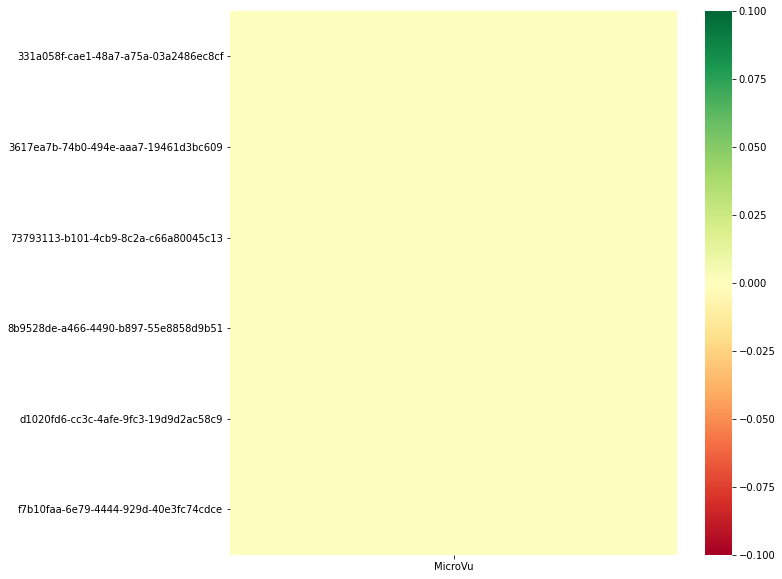

In [383]:
classification_results = reference_instances.to_frame(name = 'MicroVu')
plot_heatmap(classification_results)

# Data exploration

### Grouping data by instance

In [384]:
# Group the measurements based on the process instance id
instance_measurements = data.groupby('instance', sort = False)[['value', 'timestamp']]

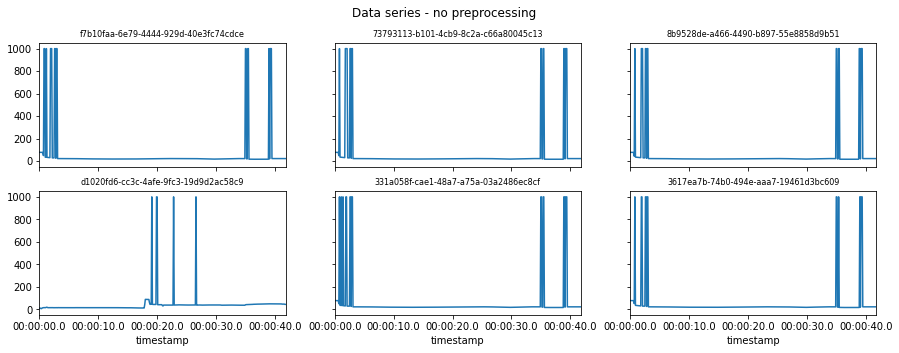

In [385]:
# First plot of all data series
plot_instance_data(instance_measurements, x = 'timestamp', y = 'value', n_cols = 3, figsize = (15, 5), title = "Data series - no preprocessing")

__Plot outcome - Takeaway:__<br>
The big spikes occuring in every series are a first issue that must be tackled. We've heard these are due to ledges that are observed during the measuring process. They should come from 'chips' on the rook, as the parts are not perfectly clean upon this measurement process via the Keyence. Note for possibly future issues: Oil/Kühlemulsion may also interfere the measurement!

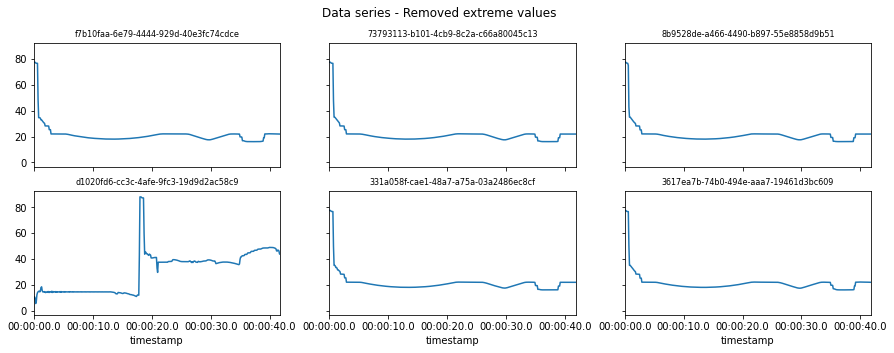

In [386]:
# Filter out spikes from the series to remove faulty measurements coming from ledges
df = data
df['value'] = df['value'].where(df['value'] < 999).fillna(method='bfill')

# Normalize the measurement timestamps
df['timestamp'] = (df['timestamp'] - df.groupby('instance')['timestamp'].transform('min'))

# Group measurement data according to process instance
instance_measurements = df.groupby('instance', sort = False)[['value', 'timestamp', 'log_order']]

plot_instance_data(instance_measurements, x = 'timestamp', y = 'value', n_cols = 3, figsize = (15, 5), title = "Data series - Removed extreme values")

__Plot outcome - Takeaway:__<br>
The removal of the ledge spikes now provides a better picture on the different data series. By intuition one would say the data series of process instance _'fac9e4a3-9e3a-467c-8d1c-9c398186ced4'_ probably shows a faulty rook. We can check that.<br>
<br>
Also, some data series show some suspicious low measurements (data points) right in the beginning. We can filter out these measurements and plot the data again.

In [387]:
reference_instances['d1020fd6-cc3c-4afe-9fc3-19d9d2ac58c9']

False

As we already assumed, the rook measured in process instance _'d1020fd6-cc3c-4afe-9fc3-19d9d2ac58c9'_ is faulty.

In [388]:
data.head()

instance              timestamp  value  \
0  f7b10faa-6e79-4444-929d-40e3fc74cdce        0 days 00:00:00  77.72   
1  f7b10faa-6e79-4444-929d-40e3fc74cdce 0 days 00:00:00.100000  77.70   
2  f7b10faa-6e79-4444-929d-40e3fc74cdce 0 days 00:00:00.200000  77.60   
3  f7b10faa-6e79-4444-929d-40e3fc74cdce 0 days 00:00:00.300000  77.04   
4  f7b10faa-6e79-4444-929d-40e3fc74cdce 0 days 00:00:00.400000  76.86   

   log_order  batch upright_value  
0          1     10          None  
1          3     10          None  
2         12     10          None  
3         36     10          None  
4         49     10          None

In [389]:
# Making diff for value series
def find_spikes(group_data):
    df = group_data
    delta = 999
    i = 1
    while delta > 0 and i < 5:
        df['index'] = np.arange(0, len(df), 1)
        df['delta_1'] = abs(df['value'].diff(periods = -2))
        df['delta_2'] = abs(df['value'].diff(periods = 2))
        filter_1 = df['delta_1'] < 0.02
        filter_2 = df['delta_2'] < 0.02
        df = df.where((filter_1 & filter_2) | (df['index'] > 10)).dropna()
        rows = df.head(4)
        delta_1 = max(rows['delta_1'])
        delta_2 = max(rows['delta_2'])
        delta = max(delta_1, delta_2)
        i = i + 1
    return df

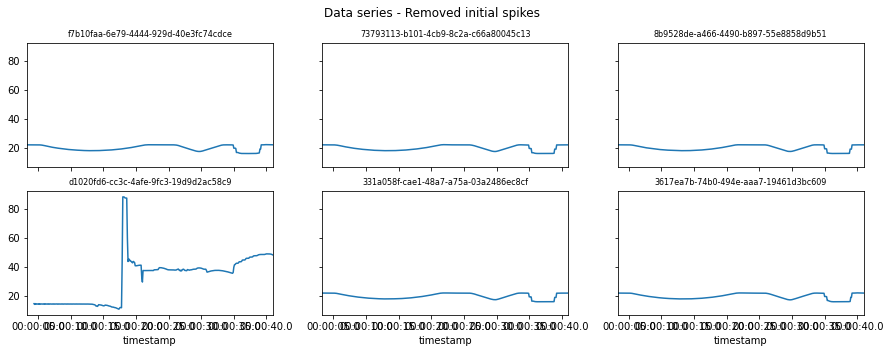

In [390]:
# Group measurement data according to process instance
#instance_measurements = df.groupby('instance', sort = False)[['value', 'timestamp', 'log_order']]

cleaned_measurements = instance_measurements.apply(find_spikes).reset_index()
cleaned_measurements.drop('level_1', axis = 1, inplace = True)
instance_measurements = cleaned_measurements.groupby('instance', sort = False)[['value', 'timestamp']]

plot_instance_data(instance_measurements, x = 'timestamp', y = 'value', n_cols = 3, figsize = (15, 5), title = "Data series - Removed initial spikes")

In [391]:
instance_measurements.apply(print)

     value              timestamp
0    22.02 0 days 00:00:03.100000
1    22.02 0 days 00:00:03.200000
2    22.02 0 days 00:00:03.300000
3    22.02 0 days 00:00:03.400000
4    22.02 0 days 00:00:03.500000
..     ...                    ...
377  22.06 0 days 00:00:40.800000
378  22.04 0 days 00:00:40.900000
379  22.03        0 days 00:00:41
380  22.03 0 days 00:00:41.100000
381  22.02 0 days 00:00:41.200000

[382 rows x 2 columns]
     value              timestamp
382  22.03 0 days 00:00:03.300000
383  22.03 0 days 00:00:03.400000
384  22.02 0 days 00:00:03.500000
385  22.02 0 days 00:00:03.600000
386  22.02 0 days 00:00:03.700000
..     ...                    ...
755  22.01 0 days 00:00:40.600000
756  22.01 0 days 00:00:40.700000
757  22.01 0 days 00:00:40.800000
758  22.01 0 days 00:00:40.900000
759  22.01        0 days 00:00:41

[378 rows x 2 columns]
      value              timestamp
760   22.03 0 days 00:00:03.300000
761   22.03 0 days 00:00:03.400000
762   22.02 0 days 00:00:03.500

Empty DataFrame
Columns: []
Index: []

<AxesSubplot:>

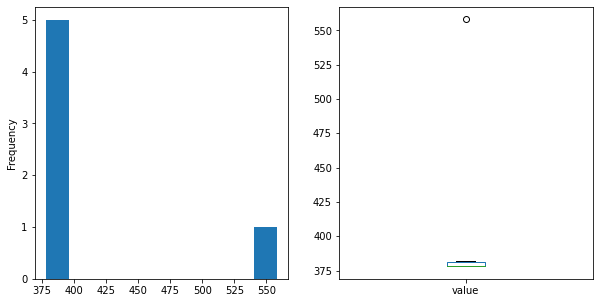

In [392]:
data_point_counts = instance_measurements.count()['value']

fig, ax = plt.subplots(ncols = 2, figsize=(10,5))

# Plot data point count as histogram
data_point_counts.plot(kind = 'hist', ax = ax[0])

# Plot data point count as boxplot
data_point_counts.plot(kind = 'box', ax = ax[1])

The plots show that the measurements are containing about 1800-1900 single data points normally.<br>
However, there is a single outlier, that comes with more than 2700 data points.

In [393]:
data_point_counts.sort_values(ascending = False).head(1)

instance
d1020fd6-cc3c-4afe-9fc3-19d9d2ac58c9    558
Name: value, dtype: int64

It can be seen, that the outlier here is coming from the already known faulty rook (process instance _'fac9e4a3-9e3a-467c-8d1c-9c398186ced4'_).

### Duration of measurement process

We can check out the duration of the measurement process for the single rooks.<br>
Maybe it's possible to find a relation between amount of data points and general time duration.

In [394]:
# Calculate total time duration of the measurement processes
times = instance_measurements.apply(lambda x: x['timestamp'].dt.total_seconds().max())

# Plot times in a histogram
times.plot(kind = 'hist')

<AxesSubplot:ylabel='Frequency'>

# Cluster analysis

## Data preparation

I'm taking the data that has been prepared in the previous section as basis.

In [395]:
data = instance_measurements

<AxesSubplot:ylabel='Frequency'>

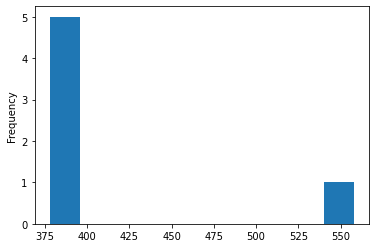

In [396]:
data.count()['value'].plot(kind = 'hist')

In [397]:
time_deltas = data.apply(lambda x: np.median(x['timestamp'].diff())).to_list()
time_resolution = np.median(time_deltas)

In [398]:
begin_times = data.apply(lambda x: x['timestamp'].min())
begin_time = np.median(begin_times)

max_count = data.count()['value'].min()
max_timedelta = time_resolution * (max_count - 1) + begin_time

freq = str(time_resolution.microseconds) + 'U'

begin_time = pd.to_timedelta(0, unit = 'S')

time_range = pd.timedelta_range(begin_time, max_timedelta, freq = freq)

clustering_input = data.apply(lambda x: x.set_index('timestamp').reindex(time_range, method = 'bfill')).reset_index()
clustering_input.rename(columns = {'level_1':'timestamp'}, inplace = True)
clustering_input = clustering_input.groupby('instance', sort = False)

In [399]:
clustering_input.count()#['value'].plot(kind = 'hist')

timestamp  value
instance                                              
f7b10faa-6e79-4444-929d-40e3fc74cdce        411    411
73793113-b101-4cb9-8c2a-c66a80045c13        411    411
8b9528de-a466-4490-b897-55e8858d9b51        411    411
d1020fd6-cc3c-4afe-9fc3-19d9d2ac58c9        411    411
331a058f-cae1-48a7-a75a-03a2486ec8cf        411    411
3617ea7b-74b0-494e-aaa7-19461d3bc609        411    411

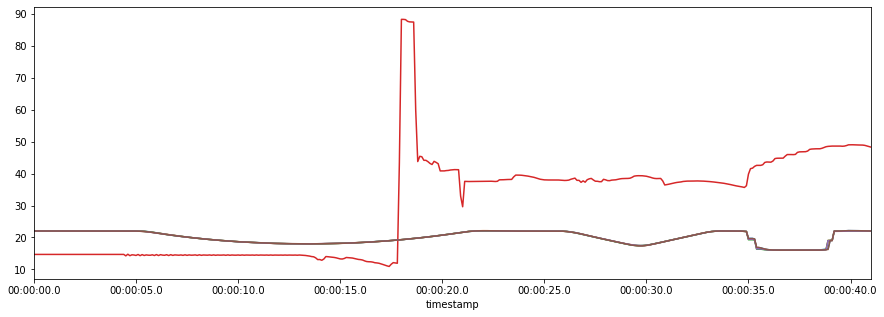

In [400]:
fig, ax = plt.subplots(figsize=(15,5))
for label, instance_data in clustering_input:
    instance_data.plot(x = 'timestamp', y = 'value', ax=ax, label=label, legend = None)
plt.show()

### Clustering Input Data

In [401]:
X = clustering_input.apply(lambda x: x['value'].to_list()).to_list()
X = np.array(X)
instances = clustering_input.apply(lambda x: x.name).to_list()

## Normal clustering approach - Traditional algorithms

## DBSCAN Clustering

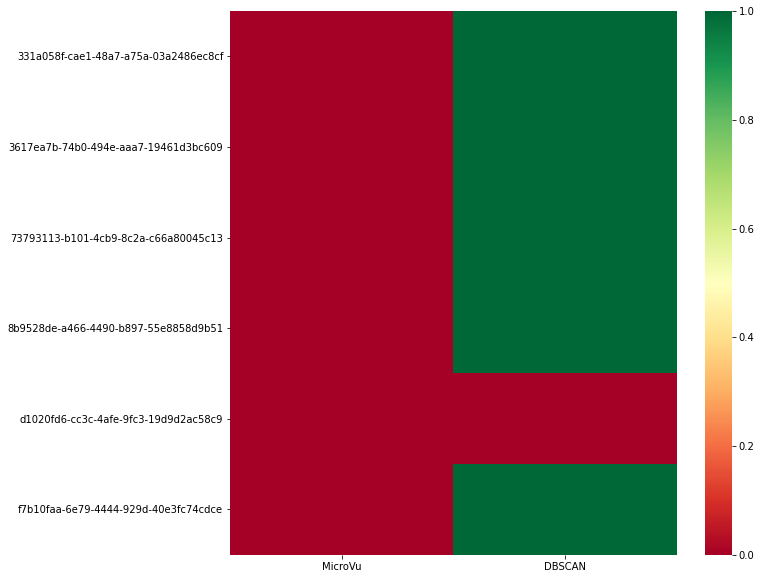

In [402]:
db = DBSCAN(eps = 30)


labels = db.fit_predict(X)
labels

#labels = -labels
labels = labels + 1
labels = [x > 0 for x in labels]
results = pd.Series(labels, index = instances)
results.sort_index(inplace = True)
heatmap_data = classification_results
heatmap_data['DBSCAN'] = results.values
plot_heatmap(heatmap_data)

### Function definitions for later error calculation based on clustering centroids

In [403]:
def calculate_error(data, centroid):
    errors = []
    errors.append(centroid - data)
    for i in range(1, 50):
        errors.append(centroid[i:] - data[:-i])
        errors.append(centroid[:-i] - data[i:])
    summed_errors = [np.median(abs(x)) for x in errors]
    val, idx = min((val, idx) for (idx, val) in enumerate(summed_errors))
    return errors[idx]

In [404]:
def calculate_faulty_parts(error_treshold, filter_threshold, errors, clustering_labels, desired_cluster_label):
    filter_threshold = error_treshold * filter_threshold
    faults = []
    for i in range(len(errors)):
        instance_data = errors[i]
        instance_data = abs(instance_data)
        filtered =  instance_data[instance_data < filter_treshold]
        fault = filtered[filtered > error_treshold]
        if fault.any():
            faults.append(len(fault))
        else:
            faults.append(0)

    faulty_instances = []

    for instance, fault, label in zip(instances, faults, clustering_labels):
        if (fault >= 5 or label != desired_cluster_label):
            faulty_instances.append(instance)

    labels = [x not in faulty_instances for x in instances]
    return labels

In [405]:
def plot_errors(errors, target_instances):
    instance = 0
    for instance_errors in errors:
        if instance in targets:
            coordinates = np.arange(0, len(instance_errors), 1)
            plt.bar(x = coordinates, height = instance_errors)
            plt.show()
        instance = instance + 1

## K-Means Clustering

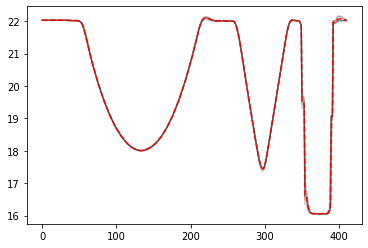

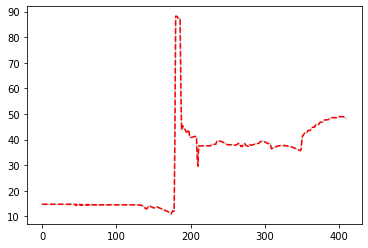

In [406]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
labels = kmeans.fit_predict(X)

for i in range(n_clusters):
    for xx in X[labels == i]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(kmeans.cluster_centers_[i].ravel(), "r--")
    plt.show()

#labels == 1

centroid = kmeans.cluster_centers_[0].ravel()

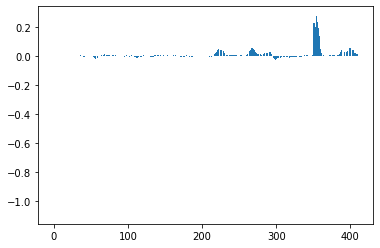

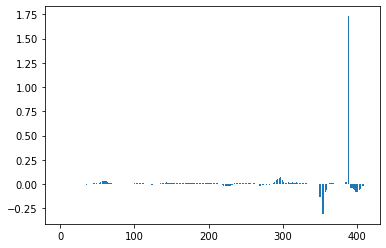

In [407]:
errors = [calculate_error(x, centroid) for x in X]
labels = calculate_faulty_parts(0.1, 5, errors, labels, 0)
plot_errors(errors, np.arange(0, len(errors), 1))

In [408]:
results = pd.Series(labels, index = instances)
results.sort_index(inplace = True)
heatmap_data['K_Means'] = results.values
plot_heatmap(heatmap_data)

## DTW Clustering

In [409]:
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesResampler

X_tsd = to_time_series_dataset(X)

#sz = 500
#X = TimeSeriesResampler(sz=sz).fit_transform(X_tsd)

fig, ax = plt.subplots(figsize=(15,10))
for series in X_tsd:
    ax.plot(series)
plt.show()

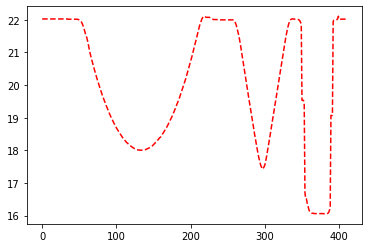

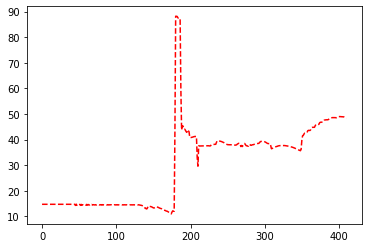

In [410]:
from tslearn.clustering import TimeSeriesKMeans

n_clusters = 2
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=3)
labels = model.fit_predict(X_tsd)

for i in range(n_clusters):
    #for xx in X[labels == i]:
        #plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model.cluster_centers_[i].ravel(), "r--")
    plt.show()

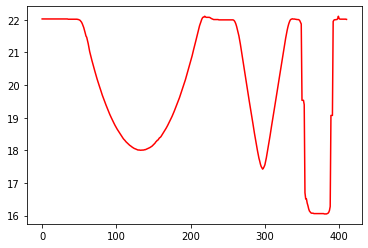

In [411]:
dtw_centroid = model.cluster_centers_[0].ravel()
plt.plot(dtw_centroid, "r-")

In [412]:
errors = [calculate_error(x, dtw_centroid) for x in X]
labels = calculate_faulty_parts(0.1, 2, errors, labels, 0)

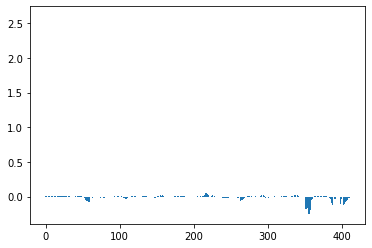

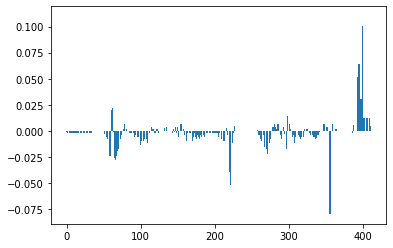

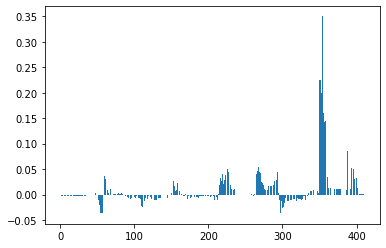

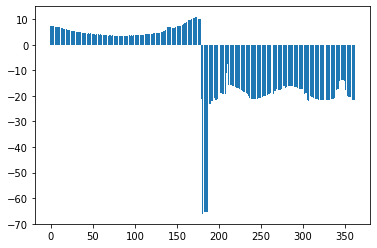

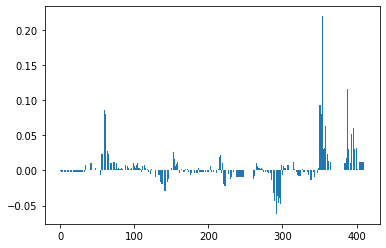

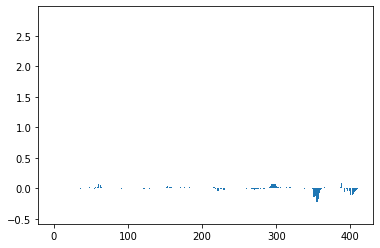

In [413]:
plot_errors(errors, np.arange(0, len(errors), 1))

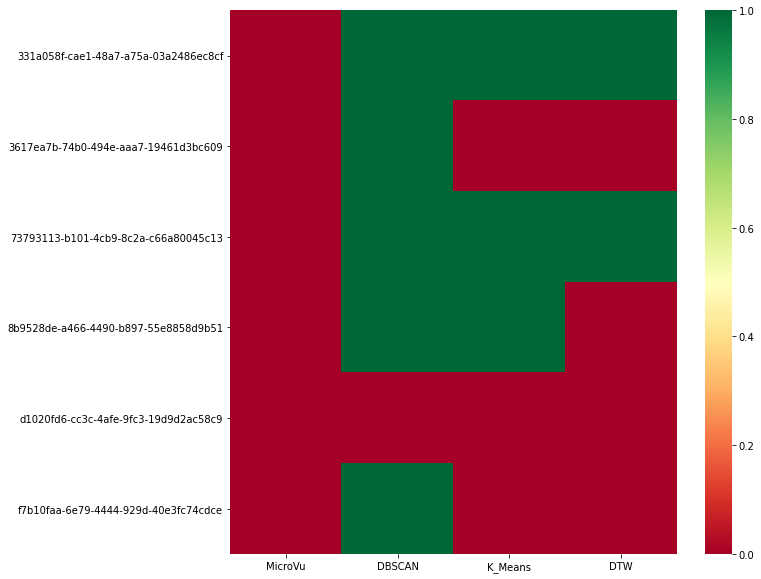

In [414]:
results = pd.Series(labels, index = instances)
results.sort_index(inplace = True)
heatmap_data['DTW'] = results.values
plot_heatmap(heatmap_data)